In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
pd.set_option('display.max_columns', 500)


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")

We began by looking at the accepted loan data from the years 2013 and 2014. We did not look at loan data prior to 2013 because Lending Club [changed its underwriting policy in late 2012](https://www.lendacademy.com/lending-club-underwriting-changes/), which "removed the highest risk borrowers that were previously being approved and ... added back in the best borrowers from previously declined populations." Thus, we did not want the loan acceptance policies/strategies from 2012 and before to influence our models, since they are not representative of the way Lending Club accepts loans today.

When we looked through the 2013-2014 data, we noticed that many columns included forward-looking information regarding whether or not a borrower had defaulted on his/her loan. These columns included "total_pymnt" (total payments received to date for total amount funded), "total_rec_prncp" (principal received to date), "last_pymnt_d" (the last month a payment was received), and "last_pymnt_amnt" (last total payment amount received). Other future-looking columns began with words such as "hardship," "debt_settlement," and "settlement." We ignored these columns for the rest of our analysis since this information would not be available to an investor at the time of investment.

Lastly, we ignored columns that might implicitly discriminate against individuals of certain socio-economic classes. Such features include "zip_code" and "addr_state" since important information regarding a person can be inferred from the location of his/her residence.

After selecting features that we thought could help us predict whether or not an individual will default on a loan, we explored the associations between many of the features and the defaulted loans. Below we show some of our exploratory data analysis of features that would eventually be used to model whether an individual would default on a loan.

In [2]:
#read in 2013 and 2014 data
data_2013 = pd.read_csv("../data/2012_13_loan_data/LoanStats3b.csv", delimiter=",", encoding='latin-1');

data_2014_a = pd.read_csv("../data/2014_loan_data/LoanStats_2014_A.csv", delimiter=",");
data_2014_b = pd.read_csv("../data/2014_loan_data/LoanStats_2014_B.csv", delimiter=",");
data_2014_c = pd.read_csv("../data/2014_loan_data/LoanStats_2014_C.csv", delimiter=",");
data_2014_d = pd.read_csv("../data/2014_loan_data/LoanStats_2014_D.csv", delimiter=",");
data_2014_full = pd.concat([data_2014_a, data_2014_b, data_2014_c, data_2014_d]);

print(data_2013.shape);
print(data_2014_full.shape)


/Users/bhavenpatel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (47,123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/bhavenpatel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(134814, 145)
(235629, 145)


In [3]:
#see if both data sets have same columns
print(len(data_2013.columns))
print(len(data_2014_full.columns))
assert(np.all(data_2013.columns == data_2014_full.columns));

145
145


In [4]:
#concatenate 2013 and 2014 data
train_data = pd.concat([data_2013, data_2014_full], axis = 0);
train_data.reset_index();

#add column for Default status. Default=1, Paid=0
train_data['Default'] = 1;
train_data.loc[train_data.loan_status == "Fully Paid", 'Default'] = 0;
display(train_data.head());

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,Default
0,NaN,NaN,10000,10000,10000.0,36 months,9.67%,321.13,B,B1,Registered Nurse,7 years,MORTGAGE,102000.0,Not Verified,Dec-13,Fully Paid,n,NaN,NaN,debt_consolidation,Clean Up,027xx,MA,15.55,2,Oct-89,0,11.0,NaN,9,0,9912,44.40%,22,f,0.0,0.0,11560.462180,11560.46,10000.0,1560.46,0.0,0.0,0.0,Jan-17,320.91,NaN,Dec-16,0,54.0,1,Individual,NaN,NaN,NaN,0,0,39143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22300,NaN,NaN,NaN,3,4349.0,973.0,89.4,0,0,243.0,290,23,8,0,25.0,11.0,8.0,11.0,1,3,4,3,6,9,6,13,4,9,0.0,0,0,1,77.3,66.7,0,0,58486,39143,9200,36186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,12000,12000,12000.0,36 months,6.62%,368.45,A,A2,MANAGER INFORMATION DELIVERY,10+ years,MORTGAGE,105000.0,Not Verified,Dec-13,Fully Paid,n,NaN,NaN,debt_consolidation,UNIVERSAL CARD,060xx,CT,14.05,0,Mar-94,1,43.0,NaN,12,0,13168,21.60%,22,w,0.0,0.0,13263.954640,13263.95,12000.0,1263.95,0.0,0.0,0.0,Jan-17,368.20,NaN,Oct-18,0,NaN,1,Individual,NaN,NaN,NaN,0,0,267646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61100,NaN,NaN,NaN,4,26765.0,39432.0,25.0,0,0,146.0,237,20,3,4,20.0,NaN,3.0,43.0,0,2,2,5,5,9,8,9,2,12,0.0,0,0,2,95.5,0.0,0,0,333044,42603,52600,42769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,20800,20800,20800.0,36 months,13.53%,706.16,B,B5,Operations Manager,10+ years,RENT,81500.0,Verified,Dec-13,Fully Paid,n,NaN,Borrower added on 12/31/13 > My goal is to p...,debt_consolidation,Reducing Debt to Purchase Home,100xx,NY,16.73,0,Jun-98,2,64.0,NaN,29,0,23473,54.50%,41,f,0.0,0.0,23926.640010,

<hr>

## Does loan amount differ between repaid and defaulted loans?

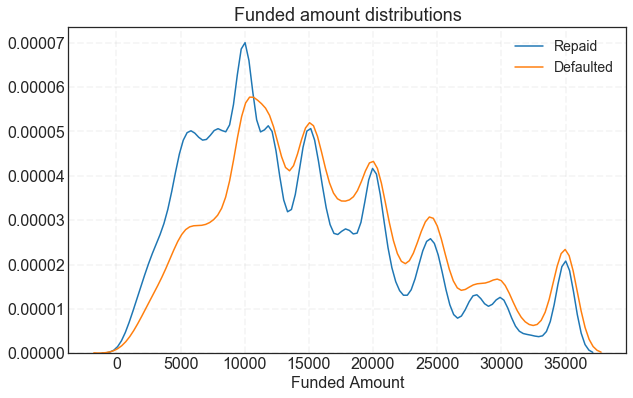

In [5]:
fig = plt.figure(figsize=(10,6));
ax = plt.subplot(1,1,1);
fontsize= 16;

ax.tick_params(labelsize=fontsize);
ax.set_xlabel(xlabel="Funded Amount", fontsize=fontsize);
ax.set_title(label="Funded amount distributions", fontsize=18)
ax.grid(True, lw=1.75, ls='--', alpha=0.2)
#plot the funded amount for loans that were paid back and those that defaulted
sns.kdeplot(data = train_data.loc[train_data['Default'] == 0, "funded_amnt"], label = "Repaid", ax = ax);
sns.kdeplot(data = train_data.loc[train_data['Default'] == 1, "funded_amnt"], label = "Defaulted", ax = ax);
ax.legend(fontsize=14);

plt.show()

The distributions of loan amounts for both repaid and defaulted loans overlap quite a bit. However, there is a slight left shift in the distribution for loan amounts that were repaid, indicating that loans with lower amounts have a good chance of being repaid. This could possibly be exploited for higher rates of return.
<hr>

## Do interest rates differ between repaid and defaulted loans?

In [6]:
#convert interest rates to decimals

def convert_ir(x):
    rate = float(x[:-1]);
    return rate/100;

train_data.int_rate = train_data.int_rate.map(convert_ir);
train_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,Default
0,NaN,NaN,10000,10000,10000.0,36 months,0.0967,321.13,B,B1,Registered Nurse,7 years,MORTGAGE,102000.0,Not Verified,Dec-13,Fully Paid,n,NaN,NaN,debt_consolidation,Clean Up,027xx,MA,15.55,2,Oct-89,0,11.0,NaN,9,0,9912,44.40%,22,f,0.0,0.0,11560.462180,11560.46,10000.0,1560.46,0.0,0.0,0.0,Jan-17,320.91,NaN,Dec-16,0,54.0,1,Individual,NaN,NaN,NaN,0,0,39143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22300,NaN,NaN,NaN,3,4349.0,973.0,89.4,0,0,243.0,290,23,8,0,25.0,11.0,8.0,11.0,1,3,4,3,6,9,6,13,4,9,0.0,0,0,1,77.3,66.7,0,0,58486,39143,9200,36186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
1,NaN,NaN,12000,12000,12000.0,36 months,0.0662,368.45,A,A2,MANAGER INFORMATION DELIVERY,10+ years,MORTGAGE,105000.0,Not Verified,Dec-13,Fully Paid,n,NaN,NaN,debt_consolidation,UNIVERSAL CARD,060xx,CT,14.05,0,Mar-94,1,43.0,NaN,12,0,13168,21.60%,22,w,0.0,0.0,13263.954640,13263.95,12000.0,1263.95,0.0,0.0,0.0,Jan-17,368.20,NaN,Oct-18,0,NaN,1,Individual,NaN,NaN,NaN,0,0,267646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61100,NaN,NaN,NaN,4,26765.0,39432.0,25.0,0,0,146.0,237,20,3,4,20.0,NaN,3.0,43.0,0,2,2,5,5,9,8,9,2,12,0.0,0,0,2,95.5,0.0,0,0,333044,42603,52600,42769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0
2,NaN,NaN,20800,20800,20800.0,36 months,0.1353,706.16,B,B5,Operations Manager,10+ years,RENT,81500.0,Verified,Dec-13,Fully Paid,n,NaN,Borrower added on 12/31/13 > My goal is to p...,debt_consolidation,Reducing Debt to Purchase Home,100xx,NY,16.73,0,Jun-98,2,64.0,NaN,29,0,23473,54.50%,41,f,0.0,0.0,23926.64001

In [7]:
train_data_intRate_gb = train_data.groupby(by='Default').agg({
    'int_rate':'mean'
})
train_data_intRate_gb

,int_rate
Default,
0,0.134466
1,0.161830


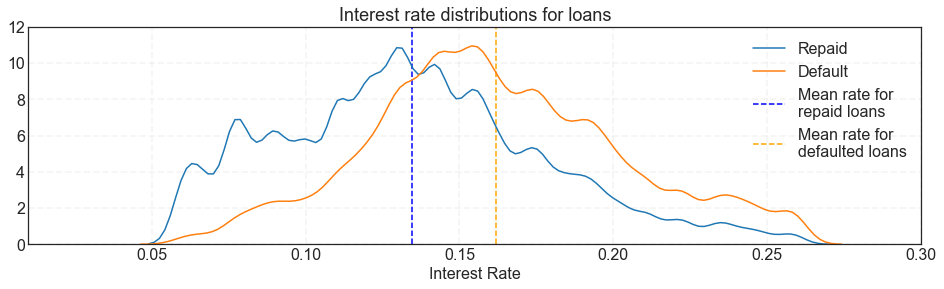

In [9]:
fig = plt.figure(figsize=(16,4));
ax = plt.subplot(1,1,1);
f_size=16;

ax.set_xlabel('Interest Rate', fontsize= f_size);
# ax.set_ylabel('Density of Distribution', fontsize= f_size);
ax.set_title('Interest rate distributions for loans', fontsize=18)
ax.set_xlim(left=0.01, right=0.3);
ax.set_ylim(bottom=0, top=12);
ax.tick_params(labelsize=f_size);
ax.grid(True, lw=1.75, ls='--', alpha=0.2)


sns.kdeplot(train_data.loc[train_data['Default'] == 0, 'int_rate'], label='Repaid', ax=ax);
ax.vlines(x=train_data_intRate_gb.int_rate[0], ymin=0, ymax=12, colors='b', linestyles='dashed', label="Mean rate for \nrepaid loans")

sns.kdeplot(train_data.loc[train_data['Default'] == 1, 'int_rate'], label='Default', ax=ax);
ax.vlines(x=train_data_intRate_gb.int_rate[1], ymin=0, ymax=12, colors='orange', linestyles='dashed', label="Mean rate for \ndefaulted loans")

ax.legend(loc='best', fontsize=f_size);

# plt.show()
# plt.savefig('Interest_rate_distrb_for_loans.png', bbox_inches='tight');

Interest rate could also be a good predictor of defaulted loans since the distribution of interest rates for repaid loans is slightly shifted to the left compared to the distribution of interest rates for defaulted loans. The means of the two distributions show some separation as well. We would expect that borrowers, who are given a lower interest rate, to repay their loans more often, most likely because it presents less of a financial burden on them. 
<hr>

## How does loan grade relate to default rate?

We can look at the default rate of loans (percentage of loans that default for a given category) with different loan grades (the result of a [formula](https://www.lendingclub.com/foliofn/rateDetail.action) that takes into account not only credit score, but also a combination of several indicators of credit risk from the credit report and loan application). Since the grade of a loan is tied with its interest rate, we would expect that high grade loans (A & B loans) have lower default rates than lower grade loans.

In [10]:
train_data_grade_gb = train_data.groupby(by='grade').agg({
    'int_rate': 'mean',
    'Default': 'mean',
    'funded_amnt': 'mean'
});
display(train_data_grade_gb)

,int_rate,Default,funded_amnt
grade,,,
A,0.075609,0.057356,14765.524662
B,0.114474,0.133106,13580.172747
C,0.146564,0.243030,14619.361694
D,0.176240,0.329321,15310.466717
E,0.207821,0.406546,17369.291467
F,0.241303,0.427656,17778.409947
G,0.257392,0.504119,20738.681836


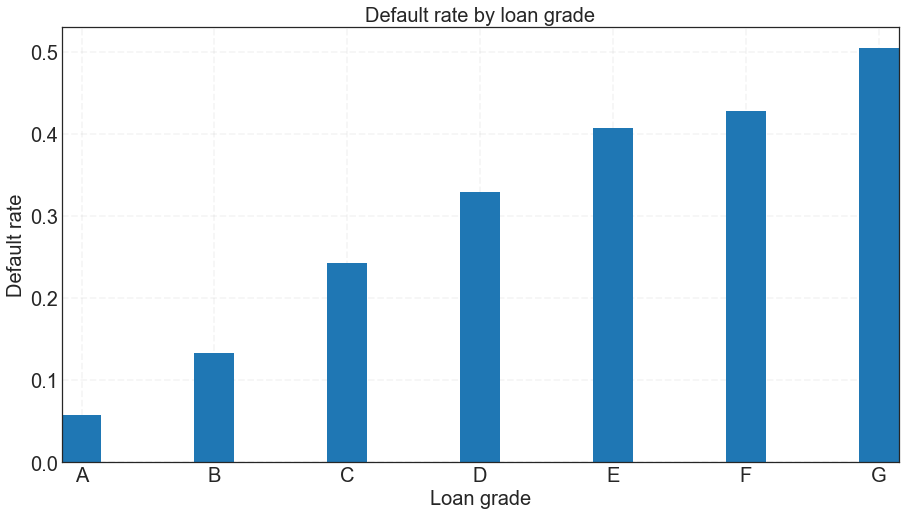

In [11]:
# font size
f_size = 20
x = np.arange(train_data_grade_gb.shape[0]); #get x locations for groups
width = 0.3; #width of bars
# make the figure
fig = plt.figure(figsize = (15,8))
ax = plt.subplot(1,1,1) # Create figure object
ax.set_xmargin(0);

ax.bar(x, train_data_grade_gb['Default'], width=width);
ax.set_xticks(x); #set locations of tick marks
# adjust size of labels on axes 
ax.tick_params(labelsize = f_size);
ax.grid(True, lw=1.75, ls='--', alpha=0.20); #include background grid #set axes titles
ax.set_xlabel('Loan grade', fontsize=f_size);
ax.set_ylabel('Default rate', fontsize=f_size);

#make labels readable
ax.set_xticklabels(train_data_grade_gb.index); #set x labels

# set figure title label
ax.set_title('Default rate by loan grade', fontsize = 20);
# ax.legend(loc='best', fontsize = f_size);
plt.show();

As expected, we see that higher grade loans (A & B) have much lower rates of default than lower grade loans (E, F, G). Thus, loan grade should be a strong feature in predicting whether a future borrower will default on a loan.
<hr>

## Is years of employment related to defaulting on a loan?

We will investigate if the number of years a borrowers has been employed has a relationship with whether a borrower repaid or defaulted on a loan.

In [12]:
def convert_empl_years(ey):
    if ey == "10+ years":
        return 10.0;
    elif ey == "< 1 year":
        return 0.0;
    else:
        return float(ey[0]);
    
#convert years employed
train_data["years_emplyd"] = train_data["emp_length"].map(convert_empl_years, na_action='ignore');

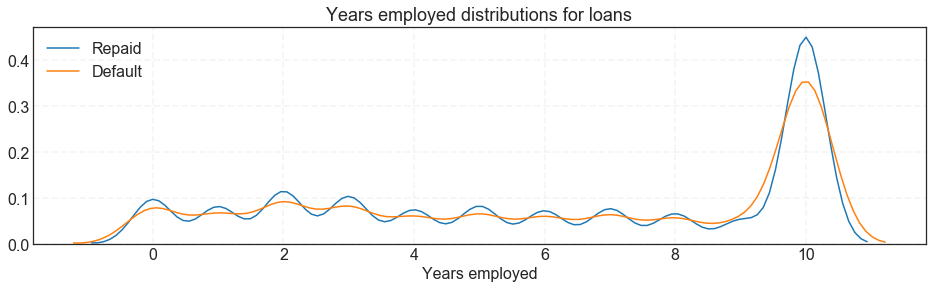

In [13]:
fig = plt.figure(figsize=(16,4));
ax = plt.subplot(1,1,1);
f_size=16;

ax.set_xlabel('Years employed', fontsize= f_size);
# ax.set_ylabel('Density of Distribution', fontsize= f_size);
ax.set_title('Years employed distributions for loans', fontsize=18)
# ax.set_xlim(left=0.01, right=0.3);
# ax.set_ylim(bottom=0, top=12);
ax.tick_params(labelsize=f_size);
ax.grid(True, lw=1.75, ls='--', alpha=0.2)


sns.kdeplot(train_data.loc[train_data['Default'] == 0, 'years_emplyd'].dropna(), label='Repaid', ax=ax);
# ax.vlines(x=train_data_intRate_gb.int_rate[0], ymin=0, ymax=12, colors='b', linestyles='dashed', label="Mean rate for \npaid loans")

sns.kdeplot(train_data.loc[train_data['Default'] == 1, 'years_emplyd'].dropna(), label='Default', ax=ax);
# ax.vlines(x=train_data_intRate_gb.int_rate[1], ymin=0, ymax=12, colors='orange', linestyles='dashed', label="Mean rate for \ndefaulted loans")

ax.legend(loc='best', fontsize=f_size);

# plt.show()
# plt.savefig('Interest_rate_distrb_for_loans.png', bbox_inches='tight');

For the most part, number of years employed does not differentiate between borrowers that paid back their loan and those that defaulted. However, we do see that a large number of borrowers that have been employed for 10+ years pay back their loans. Thus, this could be a useful feature for predicting whether a borrower will default.

Let's see if the rate of default really differs for borrowers with 10+ years of employment.

In [31]:
train_data_years_employed_gb = train_data.groupby(by="emp_length").agg({
    'int_rate': 'mean',
    'Default': 'mean'
})

#reset the index name
train_data_years_employed_gb.index.rename('Years employed', inplace=True);
train_data_years_employed_gb.columns = ['Average Interest Rate', 'Default Rate'];
train_data_years_employed_gb = train_data_years_employed_gb.reset_index();
train_data_years_employed_gb.index = np.repeat("", 11);
display(train_data_years_employed_gb)

,Years employed,Average Interest Rate,Default Rate
,1 year,0.139343,0.211387
,10+ years,0.141005,0.221191
,2 years,0.139434,0.212185
,3 years,0.139317,0.210105
,4 years,0.139589,0.210993
,5 years,0.140833,0.209720
,6 years,0.141017,0.215693
,7 years,0.141247,0.217224
,8 years,0.140500,0.222300
,9 years,0.140685,0.230964


Default rate does not actually seem to vary with how long a borrower has been employed. It is possible  that employment length combined with other features could be a predictive of defaulting on a loan.
<hr>

## Does default rate vary with purpose of the loan?

In [14]:
#group data by different purposes for loan. Calculate mean interest rate and default rate of these loans
train_data_purpose_gb = train_data.groupby(by="purpose").agg({
    'int_rate': 'mean',
    'Default': 'mean'
})
train_data_purpose_gb.columns = ['Mean Interest Rate', 'Default Rate']
display(train_data_purpose_gb)

,Mean Interest Rate,Default Rate
purpose,,
car,0.132338,0.158223
credit_card,0.125182,0.193735
debt_consolidation,0.142505,0.230878
home_improvement,0.140414,0.206318
house,0.168098,0.208421
major_purchase,0.137501,0.194250
medical,0.166117,0.219565
moving,0.180964,0.239451
other,0.170831,0.222647


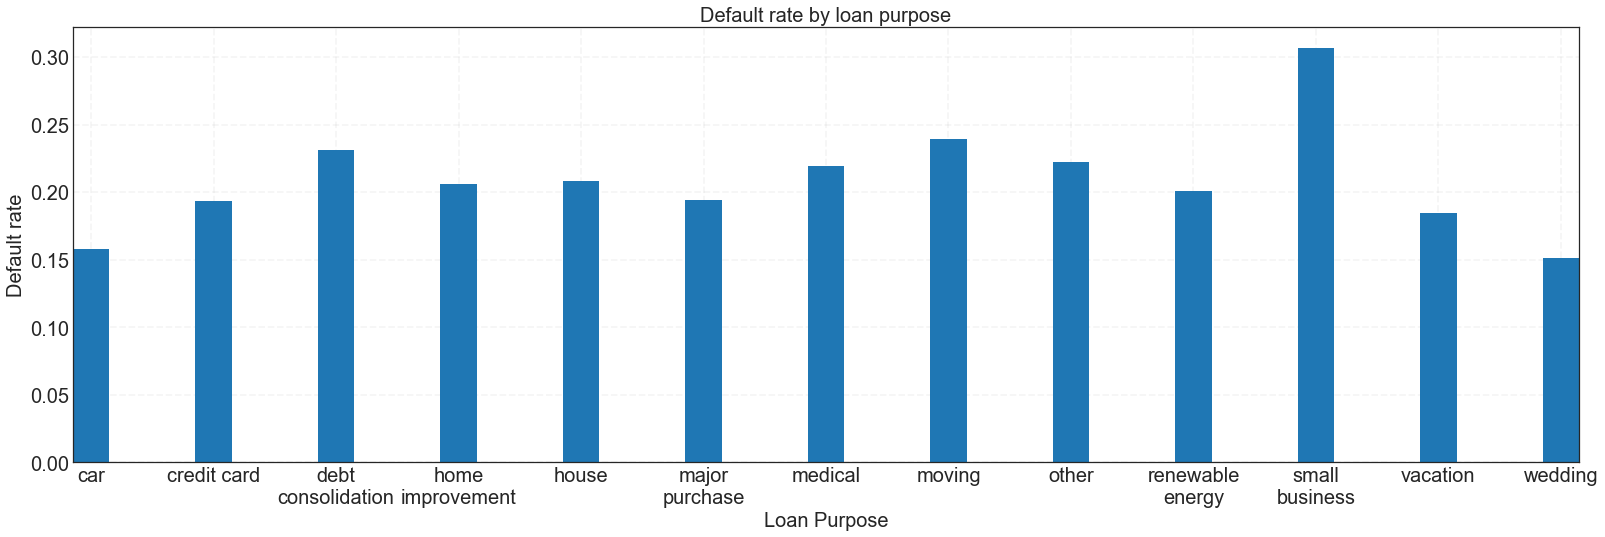

In [15]:
# font size
f_size = 20
x = np.arange(train_data_purpose_gb.shape[0]); #get x locations for groups
width = 0.3; #width of bars
# make the figure
fig = plt.figure(figsize = (27,8))
ax = plt.subplot(1,1,1) # Create figure object
ax.set_xmargin(0);

ax.bar(x, train_data_purpose_gb['Default Rate'], width=width);
ax.set_xticks(x); #set locations of tick marks
# adjust size of labels on axes 
ax.tick_params(labelsize = f_size);
ax.grid(True, lw=1.75, ls='--', alpha=0.20); #include background grid #set axes titles
ax.set_xlabel('Loan Purpose', fontsize=f_size);
ax.set_ylabel('Default rate', fontsize=f_size);

#make labels readable
x_labels = ['car', 'credit card', 'debt\nconsolidation', 'home\nimprovement', 'house', 'major\npurchase', 'medical', 'moving', 'other', 'renewable\nenergy', 'small\nbusiness', 'vacation', 'wedding'];
ax.set_xticklabels(x_labels); #set x labels

# set figure title label
ax.set_title('Default rate by loan purpose', fontsize = 20);
# ax.legend(loc='best', fontsize = f_size);
plt.show();

For the most part, the default rates for loan purpose hover between 15-20%. The default rates for 'debt consolidation' and 'moving' are slightly higher, while the default rate for 'small business' is slightly over 30%. These loan purpose categories could be useful predictors of whether or not a borrower will default on his/her loan.
<hr>

## Can total credit utilization predict defaulted loans?

Let's see if 'revol_util' (the amount of credit the borrower is using relative to all available revolving credit) has any relationship with whether borrowers will default on their loans. We will call this 'total credit utilization'. Individuals with higher credit utilization rate could be riskier individuals to lend to, since they are already carrying a high debt.

In [16]:
def convert_revol_util(x):
    num =  x[:-1]
    return float(num) / 100;

#convert the revol util to a float
train_data['revol_util_prcnt'] = train_data['revol_util'].map(convert_revol_util, na_action='ignore');
train_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,Default,years_emplyd,revol_util_prcnt
0,NaN,NaN,10000,10000,10000.0,36 months,0.0967,321.13,B,B1,Registered Nurse,7 years,MORTGAGE,102000.0,Not Verified,Dec-13,Fully Paid,n,NaN,NaN,debt_consolidation,Clean Up,027xx,MA,15.55,2,Oct-89,0,11.0,NaN,9,0,9912,44.40%,22,f,0.0,0.0,11560.462180,11560.46,10000.0,1560.46,0.0,0.0,0.0,Jan-17,320.91,NaN,Dec-16,0,54.0,1,Individual,NaN,NaN,NaN,0,0,39143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22300,NaN,NaN,NaN,3,4349.0,973.0,89.4,0,0,243.0,290,23,8,0,25.0,11.0,8.0,11.0,1,3,4,3,6,9,6,13,4,9,0.0,0,0,1,77.3,66.7,0,0,58486,39143,9200,36186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0,7.0,0.444
1,NaN,NaN,12000,12000,12000.0,36 months,0.0662,368.45,A,A2,MANAGER INFORMATION DELIVERY,10+ years,MORTGAGE,105000.0,Not Verified,Dec-13,Fully Paid,n,NaN,NaN,debt_consolidation,UNIVERSAL CARD,060xx,CT,14.05,0,Mar-94,1,43.0,NaN,12,0,13168,21.60%,22,w,0.0,0.0,13263.954640,13263.95,12000.0,1263.95,0.0,0.0,0.0,Jan-17,368.20,NaN,Oct-18,0,NaN,1,Individual,NaN,NaN,NaN,0,0,267646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61100,NaN,NaN,NaN,4,26765.0,39432.0,25.0,0,0,146.0,237,20,3,4,20.0,NaN,3.0,43.0,0,2,2,5,5,9,8,9,2,12,0.0,0,0,2,95.5,0.0,0,0,333044,42603,52600,42769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0,10.0,0.216
2,NaN,NaN,20800,20800,20800.0,36 months,0.1353,706.16,B,B5,Operations Manager,10+ years,RENT,81500.0,Verified,Dec-13,Fully Paid,n,NaN,Borrower added on 12/31/13 > My goal is to p...,debt_consolidation,Reducing Debt to Purchase Home,100xx,NY,16.73,0,Jun-98,2,

In [21]:
train_data.loc[train_data['revol_util_prcnt'] == 8.923, : ]

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,Default,years_emplyd,revol_util_prcnt
55833,NaN,NaN,3500,3500,3500.0,36 months,0.1249,117.08,B,B4,Budget Analyst,10+ years,RENT,45000.0,Verified,Apr-2014,Fully Paid,n,NaN,NaN,debt_consolidation,Debt consolidation,918xx,CA,14.67,0,Oct-1998,0,67.0,NaN,2,0,2677,892.3%,9,f,0.0,0.0,3944.66,3944.66,3500.0,444.66,0.0,0.0,0.0,Jul-2015,2422.62,NaN,Jan-2016,0,NaN,1,Individual,NaN,NaN,NaN,0,0,5668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300,NaN,NaN,NaN,0,2834.0,NaN,NaN,0,0,146.0,186,104,56,0,NaN,NaN,NaN,69.0,0,0,1,0,3,3,1,6,1,2,0.0,0,0,0,77.8,NaN,0,0,25944,5668,0,25644,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,0,10.0,8.923


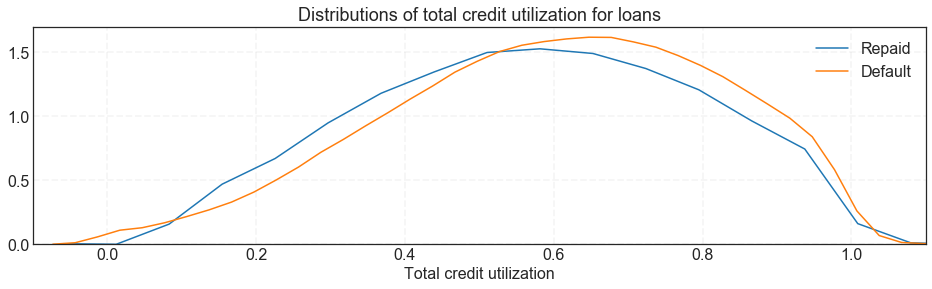

In [17]:
fig = plt.figure(figsize=(16,4));
ax = plt.subplot(1,1,1);
f_size=16;

ax.set_xlabel('Total credit utilization', fontsize= f_size);
# ax.set_ylabel('Density of Distribution', fontsize= f_size);
ax.set_title('Distributions of total credit utilization for loans', fontsize=18)
ax.set_xlim(left=-0.1, right=1.1);
# ax.set_ylim(bottom=0, top=12);
ax.tick_params(labelsize=f_size);
ax.grid(True, lw=1.75, ls='--', alpha=0.2)


sns.kdeplot(train_data.loc[train_data['Default'] == 0, 'revol_util_prcnt'].dropna(), label='Repaid', ax=ax);
# ax.vlines(x=train_data_intRate_gb.int_rate[0], ymin=0, ymax=12, colors='b', linestyles='dashed', label="Mean rate for \npaid loans")

sns.kdeplot(train_data.loc[train_data['Default'] == 1, 'revol_util_prcnt'].dropna(), label='Default', ax=ax);
# ax.vlines(x=train_data_intRate_gb.int_rate[1], ymin=0, ymax=12, colors='orange', linestyles='dashed', label="Mean rate for \ndefaulted loans")

ax.legend(loc='best', fontsize=f_size);

# plt.show()
# plt.savefig('Interest_rate_distrb_for_loans.png', bbox_inches='tight');

The distributions of 'total credit utilization' for borrowers that repaid their loans versus borrowers that defaulted overlap quite a bit. The distribution for borrowers than paid back their loans is a bit left shifted, indicating that borrowers with lower total credit utilization tend to repay their loans more often. However, it is unclear if total credit utilization is a good predictor.
<hr>

## Is debt-to-income ratio (dti) predictive of defaulted loans?

Let's see if 'dti' (a ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.) has any relationship with whether borrowers will default on their loans.

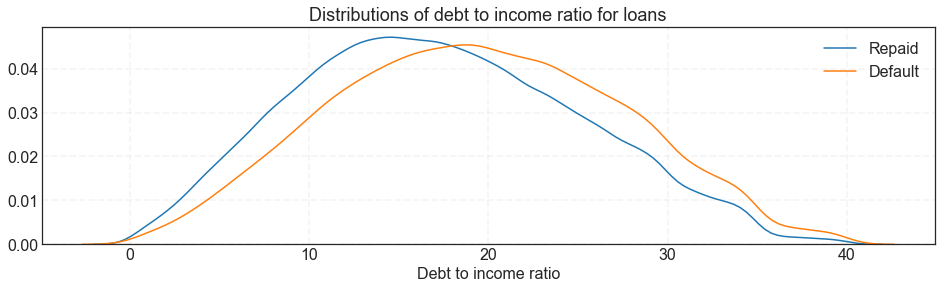

In [18]:
fig = plt.figure(figsize=(16,4));
ax = plt.subplot(1,1,1);
f_size=16;

ax.set_xlabel('Debt to income ratio', fontsize= f_size);
ax.set_title('Distributions of debt to income ratio for loans', fontsize=18)
# ax.set_xlim(left=-0.1, right=1.1);
# ax.set_ylim(bottom=0, top=12);
ax.tick_params(labelsize=f_size);
ax.grid(True, lw=1.75, ls='--', alpha=0.2)


sns.kdeplot(train_data.loc[train_data['Default'] == 0, 'dti'].dropna(), label='Repaid', ax=ax);
# ax.vlines(x=train_data_intRate_gb.int_rate[0], ymin=0, ymax=12, colors='b', linestyles='dashed', label="Mean rate for \npaid loans")

sns.kdeplot(train_data.loc[train_data['Default'] == 1, 'dti'].dropna(), label='Default', ax=ax);
# ax.vlines(x=train_data_intRate_gb.int_rate[1], ymin=0, ymax=12, colors='orange', linestyles='dashed', label="Mean rate for \ndefaulted loans")

ax.legend(loc='best', fontsize=f_size);

# plt.show()
# plt.savefig('Interest_rate_distrb_for_loans.png', bbox_inches='tight');

Similar to 'interest rate' and 'total credit utilization', we see that the distribution of 'dti' for borrowers that repaid their loans is shifted to the left slightly when compared to the distribution of 'dti' for borrowers that defaulted. This predictor could also be useful in identifying future borrowers that will default on their loans.
<hr>

## Is home ownership status associated with default rate?

We would also like to see if there is any relationship between the 'home owenership status' of borrowers and defaulting on a loan. 'Home owenrship status' tells us whether a borrower owns, rents, or has a mortage for a home.

In [30]:
train_data.home_ownership.unique()

array(['MORTGAGE', 'RENT', 'OWN', 'ANY'], dtype=object)

In [34]:
train_data_home_gb = train_data.groupby(by='home_ownership').agg({
    'home_ownership': 'count',
    'Default': 'mean',
    'int_rate': 'mean'
})

train_data_home_gb.columns = ['Count', 'Default Rate', 'Average Interest Rate']
display(train_data_home_gb)

,Count,Default Rate,Average Interest Rate
home_ownership,,,
ANY,1,0.000000,0.116700
MORTGAGE,192002,0.208045,0.137207
OWN,34258,0.223101,0.141891
RENT,144182,0.233580,0.144476


In [38]:
train_data_home_gb['Default Rate'][1:4]

home_ownership
MORTGAGE    0.208045
OWN         0.223101
RENT        0.233580
Name: Default Rate, dtype: float64

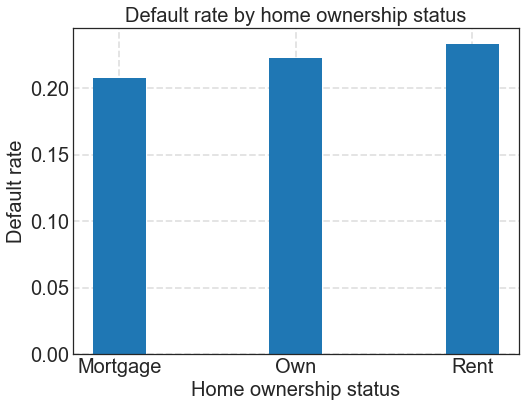

In [47]:
# font size
f_size = 20
x = np.arange(train_data_home_gb.shape[0]-1); #get x locations for groups
width = 0.3; #width of bars
# make the figure
fig = plt.figure(figsize = (8,6))
ax = plt.subplot(1,1,1) # Create figure object
# ax.set_xmargin(0);

ax.bar(x, train_data_home_gb['Default Rate'][1:4], width=width);
ax.set_xticks(x); #set locations of tick marks
# adjust size of labels on axes 
ax.tick_params(labelsize = f_size);
ax.grid(True, lw=1.75, ls='--', alpha=0.60); #include background grid #set axes titles
ax.set_xlabel('Home ownership status', fontsize=f_size);
ax.set_ylabel('Default rate', fontsize=f_size);

#make labels readable
x_labels = ['Mortgage', 'Own', 'Rent'];
ax.set_xticklabels(x_labels); #set x labels

# set figure title label
ax.set_title('Default rate by home ownership status', fontsize = 20);
# ax.legend(loc='best', fontsize = f_size);
plt.show();

Default rates do not vary between the different categories of 'home owenership status' all that much, so it does not seem to have strong predictive power on whether a borrower will default on a loan.
<hr>

## Conclusion

Our EDA analysis shows that there are some helpful features, such as loan grade, purpose, and interest rate, for predicting whether or not a borrower will default on his/her loan. Our next step is to use all of the features described above and several others to train different models for prediciting whether or not a borrower will default on a loan. 